In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import random 
import re
import preprocessor as p


In [2]:
#chunksize = 10 ** 8

btcdata = pd.read_csv('../data/raw/bitcoin-tweets-2/Bitcoin_tweets.csv')
#btcdata = pd.read_csv('../data/raw/btc-tweets-2016-2019/tweets.csv', sep='delimiter', header=None, low_memory=False)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
btcdata.shape
#converting to datetime from string
btcdata["date_time"] = pd.to_datetime(btcdata["user_created"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
#btcdata.head()
#btcdata.info()
#recent = btcdata[(btcdata['date_time'] > '2021-05-01') & (btcdata['date_time'] < '2021-02-01')]
recent = btcdata[(btcdata['date_time'] > '2020-01-01') & (btcdata['date_time'] < '2021-01-01')]

recent.shape

recent.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,date_time
8,Mikcoin,NaN,"Technical Analyst | Trader\n\nNo certainty, on...",2020-11-26 23:45:46,104.0,41,238,False,2021-02-10 23:52:25,#BTC #Bitcoin #Ethereum #ETH #Crypto #cryptotr...,"['BTC', 'Bitcoin', 'Ethereum', 'ETH', 'Crypto'...",Twitter Web App,False,2020-11-26 23:45:46
30,Hugo Ramos,"Lisbon, Portugal","#bitcoin Entrepreneur, Master in Communication...",2020-09-18 16:50:23,872.0,158,1080,False,2021-02-10 23:40:48,#BTC/USD 4H. #Bitcoin consolidating between su...,"['BTC', 'Bitcoin']",Buffer,False,2020-09-18 16:50:23
33,Majin,NaN,Don’t wait Send them to hell,2020-12-21 14:14:58,4.0,4,64,False,2021-02-10 23:39:47,If #XRP can stay at this 0.5 level\nTonight sh...,"['XRP', 'Bitcoin', 'Ethereum', 'BTC']",Twitter Web App,False,2020-12-21 14:14:58
34,Mikcoin,NaN,"Technical Analyst | Trader\n\nNo certainty, on...",2020-11-26 23:45:46,104.0,41,238,False,2021-02-10 23:39:26,#BTC #Bitcoin #Ethereum #ETH #Crypto #cryptotr...,"['BTC', 'Bitcoin', 'Ethereum', 'ETH', 'Crypto'...",Twitter Web App,False,2020-11-26 23:45:46
38,CappyTrades🍀,NaN,Calling out tickers that you should probably l...,2020-10-08 23:24:36,99.0,89,1568,False,2021-02-10 23:35:27,Holy smokes! $MARA #BTC #Bitcoin https://t.co/...,"['BTC', 'Bitcoin']",Twitter Web App,False,2020-10-08 23:24:36


In [4]:
#btcdata = btcdata[["user_followers", "user_friends", "user_favourites","text"]]
btcdata.shape
#btcdata = btcdata.dropna(how="any") #dropping rows with any properties NaN
btcdata = btcdata[(btcdata["user_followers"].notna()) & (btcdata["user_friends"].notna()) & (btcdata["user_favourites"].notna())]
btcdata = btcdata.astype({"user_followers": "float64"}) #Conv datatype of df3, user_followers Col from object to int64
btcdata = btcdata[btcdata["user_friends"] != "False"]

btcdata = btcdata.astype({"user_friends": "float64"}) #Conv datatype of df3, user_followers Col from object to int64
btcdata = btcdata.astype({"user_favourites": "float64"}) #Conv datatype of df3, user_followers Col from object to int64

btcdata.shape

#btcdata.query("(user_followers == 0) & (user_friends == 0) & (user_favourites == 0)").describe()

#btcdata.describe().apply(lambda s: s.apply('{0:.5f}'.format))



(1209304, 14)

In [5]:
data = btcdata.astype({"text": "str"}, copy=True)
data['text'] = data['text'].str.replace('@[\w]+', '')


/var/folders/qj/zhs6m1zd0dvg_v7rtzjt38n80000gn/T/ipykernel_61739/3524646158.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('@[\w]+', '')


In [6]:
data['text'] = data['text'].apply(lambda x: x.lower()) #transform text to lowercase


In [7]:
#dropping the tweets from users with no followers, friends or favourites
data = data[~((data["user_followers"] == 0) | (data["user_friends"] == 0) | (data["user_favourites"] <= 1))]
#data = data.drop(data[(data["user_followers"] == 0) | (data["user_friends"] == 0) | (data["user_favourites"] == 0)].index)
data.shape


(1117689, 14)

In [8]:
#dropping the tweets with suspicious hashtags, words, bigrams, and trigrams

#any(substring in string for substring in substring_list)

#hashtags


#words
data = data[~data.text.str.contains('entertaining')]
data = data[~data.text.str.contains('subscribe')]

#bigrams
data = data[~(data.text.str.contains('free') & (data.text.str.contains('bitcoin')))]
data = data[~(data.text.str.contains('current') & (data.text.str.contains('price')))]
data = data[~(data.text.str.contains('bitcoin') & (data.text.str.contains('price')))]
data = data[~(data.text.str.contains('earn') & (data.text.str.contains('bitcoin')))]

#trigrams
data = data[~(data.text.str.contains('start') & (data.text.str.contains('trading') & (data.text.str.contains('bitcoin'))))]
data.shape



(976408, 14)

In [16]:
#Remove urls, emojis, mention,smileys. 
#p.set_options(p.OPT.URL, p.OPT.EMOJI)

#p.set_options(p.OPT.NUMBER)
#Remove urls, emojis, mention,smileys, hashtags, empty lines? space?
data['text'] = data['text'].apply(lambda x: p.clean(x)) 


In [23]:
#Check the header of formated text
data.text

0          blue ridge bank shares halted by nyse after bi...
1          today thats this thursday we will do a take wi...
2          guys evening i have read this article about bt...
4          this network is secured by nodes as of today s...
5          trade crypto on binance enjoy cashback of the ...
                                 ...                        
1209344    very interesting project airdrop bnb ebzz ethe...
1209345    what a beauty all uptargets got hit perfectly ...
1209346    checking out aidi aint going to let you lose a...
1209347    good project and strong team in a predictable ...
1209348    me i missed btc eth bnb meanwhile crypto its j...
Name: text, Length: 976408, dtype: object

In [24]:
#remove special characters
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x)) 

In [10]:
#remove extra space between words
#data['text'] = data['text'].apply(lambda x: re.sub(' +', ' ', x)) 

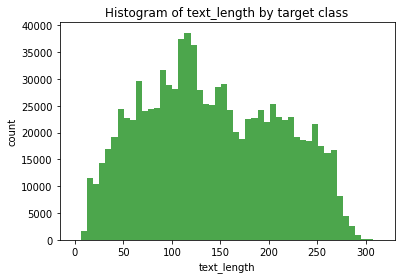

In [25]:
#get display histograms of length of cleaned tweets
data['text_length'] = data['text'].str.len()

cols = ["user_followers", "user_friends", "user_favourites"]

    #for col in cols:
col = "text_length"
#btcdata = btcdata.astype({"user_friends": "float64"}) #Conv datatype of df3, user_followers Col from object to int64
#pos_series = btcdata[col].tolist()
#neg_series = negative_examples[col].tolist()
plt.hist(data[col], 50, facecolor='g', alpha=0.7)
#plt.hist(neg_series, 50, facecolor='r', alpha=0.7, label="0")
#plt.legend(prop={"size": 10})
plt.xlabel(col)
plt.ylabel("count")
plt.ticklabel_format(style='plain')
plt.title("Histogram of " + col + " by target class")
plt.show()


Randomly select rows from each day

In [26]:
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x :x.iloc[random.choice(range(0,len(x)))])
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x: x.sample(2)).reset_index(drop=True)

selected = data.groupby(data['date_time'].dt.day).apply(lambda x: x.sample(600, random_state=889))

selected.to_csv('sample_bitcoin_tweets.csv')
selected

user_name            user_location  \
date_time                                                                  
1         832047                   scarlet love                      NaN   
          242521                        Lamberⓣ                      NaN   
          617262                  Abhishek Mule            Nagpur, India   
          318114            O M . M I S H R A 👑          Jabalpur, India   
          594386  Card₳no Dan 🇺🇸 🇯🇵 🇪🇹 🇹🇿 🌑 ADA   On the way to the MOON   
...                                         ...                      ...   
31        732040                  Mamad.englisi                      NaN   
          582781             dailycryptonetwork                      NaN   
          867392              BASEER H. JAFFERY          Ontario, Canada   
          355700                        Lindsay  England, United Kingdom   
          428012                    SatagiMoshi                      NaN   

                                                   user_description  \
date_time                                                             
1         832047       fashion and money, that's all i'm here for ✨   
          242521                                                NaN   
          617262  #WW #blogger #cryptoinvestor \nJoin our group ...   
          318114  | Engineer | Certified Financial Expert | Trad...   
          594386  IT pro & blockchain enthusiast. Decentralizati...   
...                                                             ...   
31        732040                                                  ❤   
          582781  #CRYPTO KNOWLEDGE & MORE 🎯 Every day updates o...   
          867392  Full Stack Software Developer | Working Remote...   
          355700              If it's cool and/or geeky, I like it!   
          428012  #Bitcoin Trader 24/7/365 #Altcoins Day Trader....   

                         user_created  user_followers  user_friends  \
date_time                                                             
1         832047  2021-04-01 11:45:52           489.0         592.0   
          242521  2020-04-01 14:11:12            19.0         222.0   
          617262  2020-05-01 11:12:36           157.0         321.0   
          318114  2015-02-01 09:59:09            32.0          97.0   
          594386  2019-01-01 22:36:05         60207.0         173.0   
...                               ...             ...           ...   
31        732040  2021-05-31 18:02:09            26.0          34.0   
          582781  2021-05-31 15:04:26            19.0         101.0   
          867392  2010-03-31 10:24:03          1206.0         750.0   
          355700  2008-12-31 18:40:19            60.0          97.0   
          428012  2021-05-31 18:36:59            24.0         155.0   

                  user_favourites user_verified                 date  \
date_time                                                              
1         832047            773.0         False  2021-08-06 10:46:04   
          242521            247.0         False  2021-06-21 03:12:05   
          617262            446.0         False  2021-07-30 04:56:17   
          318114            167.0         False  2021-07-03 11:44:22   
          594386          14423.0         False  2021-07-30 23:58:28   
...                           ...           ...                  ...   
31        732040           2247.0         False  2021-08-09 18:41:46   
          582781            318.0         False  2021-07-24 12:04:03   
          867392           9113.0         False  2021-08-20 19:15:48   
          355700           9548.0         False  2021-07-17 09:32:38   
          428012            356.0         False  2021-07-22 14:45:47   

                                                               text  \
date_time                                                             
1         832047  this is gonna be something great finally that ...   
          242521  really so when bitcoin doesnt exi